In [1]:
import sys

sys.path.append("../berries")


In [9]:
import random_utils
seed = 0
key_gen = random_utils.infinite_safe_keys(seed)

from datasets import load_dataset
cache_dir="$HOME/.cache/huggingface/datasets"
mnist = load_dataset("mnist", cache_dir=cache_dir, trust_remote_code=True).with_format("jax")
mnistData = mnist['train']

X_img = mnistData['image']
y = mnistData['label']
X_img_test = mnist["test"]["image"]
n_test_samples = X_img_test.shape[0]
y_test = mnist["test"]["label"]
n_samples, _, _  = X_img.shape
X_train = X_img.reshape((n_samples, 1, 28, 28))
X_test = X_img_test.reshape((n_test_samples, 1, 28, 28))
n_channels = 1
d_x = (28, 28)
d_y = len(set(y.tolist()))

In [10]:
n_test_samples = X_test.shape[0]

In [11]:
X = X_train / 255.0
X_test = X_test / 255.0

In [12]:
d_channels = 512

d_encode_hidden = 128

from jax.numpy import meshgrid, arange
pos_x1, pos_x2 = meshgrid(arange(d_x[0]), arange(d_x[1]))
pos_x1 = pos_x1.flatten()

pos_x2 = pos_x2.flatten()


x:
    a:
        1.0
    0:
        array shape: (128, 3)
    1:
        array shape: (512, 128)
    total params: 65921
y:
    a:
        1.0
    0:
        array shape: (128, 1)
    1:
        array shape: (512, 128)
    total params: 65665
total params: 131586

accuracy: 0.07999999821186066
0.09873579


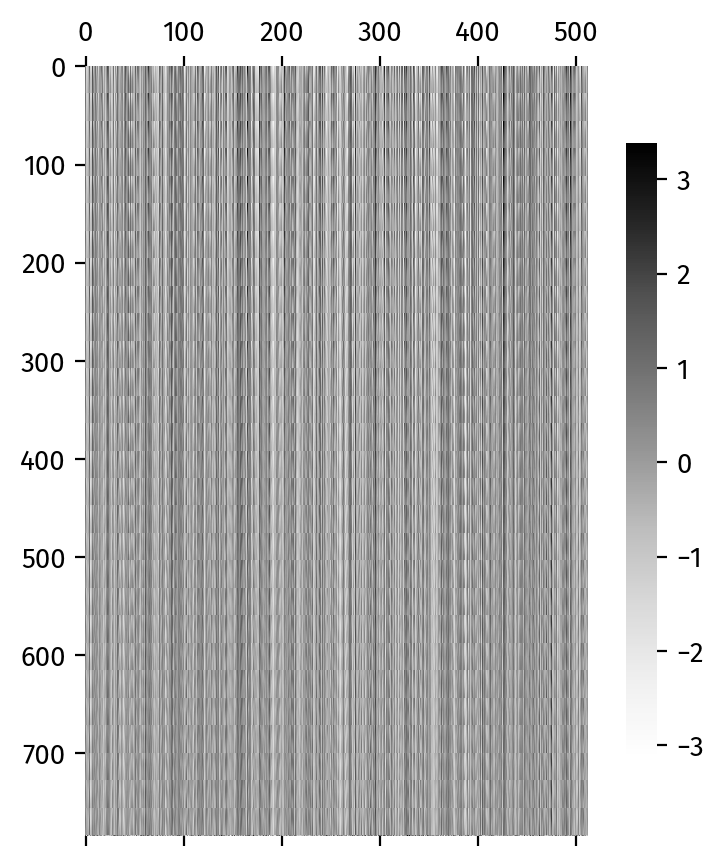

In [66]:
from jax.numpy import array, exp, mean, r_, arange
from jax import grad, jit
import nn
import importlib
importlib.reload(nn)
import pf
importlib.reload(pf)
from nn import mglu_net_config, mglu_net, sglu, sglu_config
from nn import init_weights, fmt_weights
from pf import F, _
import optax

pos_dim = 0

def gaussian_activation(a, x):
    return exp((-0.5 * x ** 2) / a ** 2)

def input_encode(W, x):
    l1 = W['0'] @ x
    a = W['a']
    a1 = gaussian_activation(a, l1)
    return W['1'] @ a1

def pos_encode(W, x1, x2, v):
    rep = array([x1, x2, v])
    return input_encode(W, rep)


def input_encode_config(in_channels, init):
    return {
        'a': {
            "size": (d_encode_hidden,),
            "const": 1.0
        },
        '0': {
            "size": ( d_encode_hidden, in_channels),
            "init": init
        },
        '1': {
            "size": (d_channels, d_encode_hidden),
            "init": init
        }
    }

def mixer_head(W, x, y):
    val_flat = x.reshape(-1)
    h_x = F(pos_encode).vmap((None, pos_dim, pos_dim, pos_dim), pos_dim)(W['x'], pos_x1, pos_x2, val_flat)
    h_y = input_encode(W['y'], array([y]))
    return r_[h_x, h_y[None, :]]

def mixer_head_config(init):
    return {
        'x': input_encode_config(3, init),
        'y': input_encode_config(1, init)
    }


def mean_loss_eu(X):
    X_mean = mean(X, axis=pos_dim)
    return mean((X - X_mean) ** 2)

def mean_loss_cos(X):
    X_mean = mean(X, axis=pos_dim)
    return optax.cosine_distance(X, X_mean)

def predict_eu(W, x):
    val_flat = x.reshape(-1)
    h_x = F(pos_encode).vmap((None, pos_dim, pos_dim, pos_dim), pos_dim)(W['x'], pos_x1, pos_x2, val_flat)
    h_X = mean(h_x, axis=pos_dim)[:, None]
    h_y_all = input_encode(W['y'], arange(d_y)[None, :])
    dist = mean((h_y_all - h_X) ** 2, axis=0)
    return dist.argmin()

def predict_cos(W, x):
    val_flat = x.reshape(-1)
    h_x = F(pos_encode).vmap((None, pos_dim, pos_dim, pos_dim), pos_dim)(W['x'], pos_x1, pos_x2, val_flat)
    h_X = mean(h_x, axis=pos_dim)[:, None]
    h_y_all = input_encode(W['y'], arange(d_y)[None, :])
    dist = mean(optax.cosine_distance(h_y_all, h_X), axis=0)
    return dist.argmin()

    


# method = {"type": "zer0", "std": 0.001}
# method = {"type": "normal", "std": 0.01}
method = {"type": "normal", "std": 0.1}

W = init_weights(next(key_gen), mixer_head_config(method))
print(fmt_weights(W)[0])
mean_loss = F(mean_loss_cos)
predict = F(predict_cos)

loss_batch = (F(mixer_head) >> mean_loss).vmap((None, 0, 0), 0) >> mean
pred_batch = F(predict).vmap((None, 0), 0)

@jit
def accuracy(W, X, y):
    return mean(pred_batch(W, X) == y)

from plot_utils import visualize_matrix
from IPython.display import display

visualize_matrix(mixer_head(W, X_test[0, :], y_test[0]), dpi=200)

acc = accuracy(W, X_test[:100, :], y_test[:100])
print(f"accuracy: {acc}")


loss0 = loss_batch(W, X_test[:100, :], y_test[:100])
print(loss0)


In [67]:
import optax
from jax.tree_util import tree_map
import init_utils



lr = 0.001
mask_fn = lambda p: tree_map(lambda x: not isinstance(x, int), p)
# opt = optax.multi_transform({"sgd": optax.rmsprop(lr), "zero": optax.set_to_zero()}, mask_fn)
opt = optax.masked(optax.adam(lr), mask_fn)
state = opt.init(W)
state_x = opt.init(W['x'])

@jit
def update(W, x, y, opt_state):
    grads = grad(loss_batch)(W, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_W = optax.apply_updates(W, updates)
    return new_W, opt_state

def loss_sep(Wx, Wy, x, y):
    return loss_batch({"x": Wx, "y": Wy}, x, y)

@jit
def update_x(W, x, y, opt_state):
    grads = grad(loss_sep)(W['x'], W['y'], x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_Wx = optax.apply_updates(W['x'], updates)
    return {'x': new_Wx, 'y': W['y']}, opt_state

In [58]:
import math, random
import jax.numpy as np



batch_size = 128

@jit
def get_accuracy_b_t(W):
    n, val = 0, 0
    for i in range(0, n_test_samples, batch_size):
        real_batch_size = min(n_test_samples - i, batch_size)
        acc_all = accuracy(W, X_test[i:i + batch_size, :], y_test[i:i + batch_size])
        val +=  mean(acc_all) * real_batch_size
        n += real_batch_size
    return val / n

@jit
def loss_b_dt(W):
    n, val = 0, 0
    for i in range(0, n_test_samples, batch_size):
        real_batch_size = min(n_test_samples - i, batch_size)
        val += mean(loss_batch(W, X_test[i:i + batch_size, :], y_test[i:i + batch_size])) * real_batch_size
        n += real_batch_size
    return val / n



def sample():
    index = random.sample(range(n_samples), batch_size)
    return X_train[index, :], y[array(index)]
xx, yy = sample()

for i in range(10000):
    W, state = update(W, xx, yy, state)
    #W, state_x = update_x(W, xx, yy, state_x)
    if i < 10 or i % 200 == 0:
        print(mean(accuracy(W, xx, yy)), get_accuracy_b_t(W), loss_b_dt(W))


print(loss_b_dt(W))


0.125 0.098 0.055186424
0.1015625 0.098 0.0543505
0.0859375 0.098 0.053528123
0.1015625 0.098 0.05273168
0.1328125 0.098 0.05194853
0.109375 0.098 0.051179796
0.0625 0.098 0.05042298
0.0703125 0.098 0.049677674
0.1171875 0.098 0.04894673
0.0703125 0.098 0.048229564
0.1015625 0.098 0.00804115
0.125 0.098 0.0027214892
0.078125 0.098 0.0013159409
0.0703125 0.098 0.0007767482
0.0859375 0.098 0.0005123906
0.109375 0.098 0.00035995003
0.109375 0.098 0.00026278896
0.0703125 0.098 0.00019650186
0.1171875 0.098 0.00014937743
0.1015625 0.098 0.000114935254
0.0703125 0.098 8.914589e-05
0.1015625 0.098 6.96378e-05
0.03125 0.098 5.468438e-05
0.1328125 0.098 4.3133557e-05
0.15625 0.098 3.42308e-05
0.0859375 0.098 2.7249824e-05
0.140625 0.098 2.1827082e-05
0.078125 0.098 1.75249e-05
0.1015625 0.098 1.41890705e-05
0.09375 0.098 1.1556817e-05
0.09375 0.098 9.4697425e-06
0.0546875 0.098 7.769662e-06
0.0703125 0.098 6.433468e-06
0.0625 0.098 5.3709396e-06
0.046875 0.098 4.4758535e-06
0.0625 0.098 3.76951

In [53]:
W0 = W

In [64]:
from sklearn.manifold import TSNE

from jax.numpy import vstack
import matplotlib.pyplot as plt

yd = input_encode(W['y'], arange(d_y)[None, :])
xyd1 = mixer_head(W, X_test[0, :], y_test[0])
xyd2 = mixer_head(W0, X_test[0, :], y_test[0])
xyd3 = mixer_head(W, X_test[1, :], y_test[1])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=20).fit_transform(vstack([xyd1, xyd3, yd.T]))

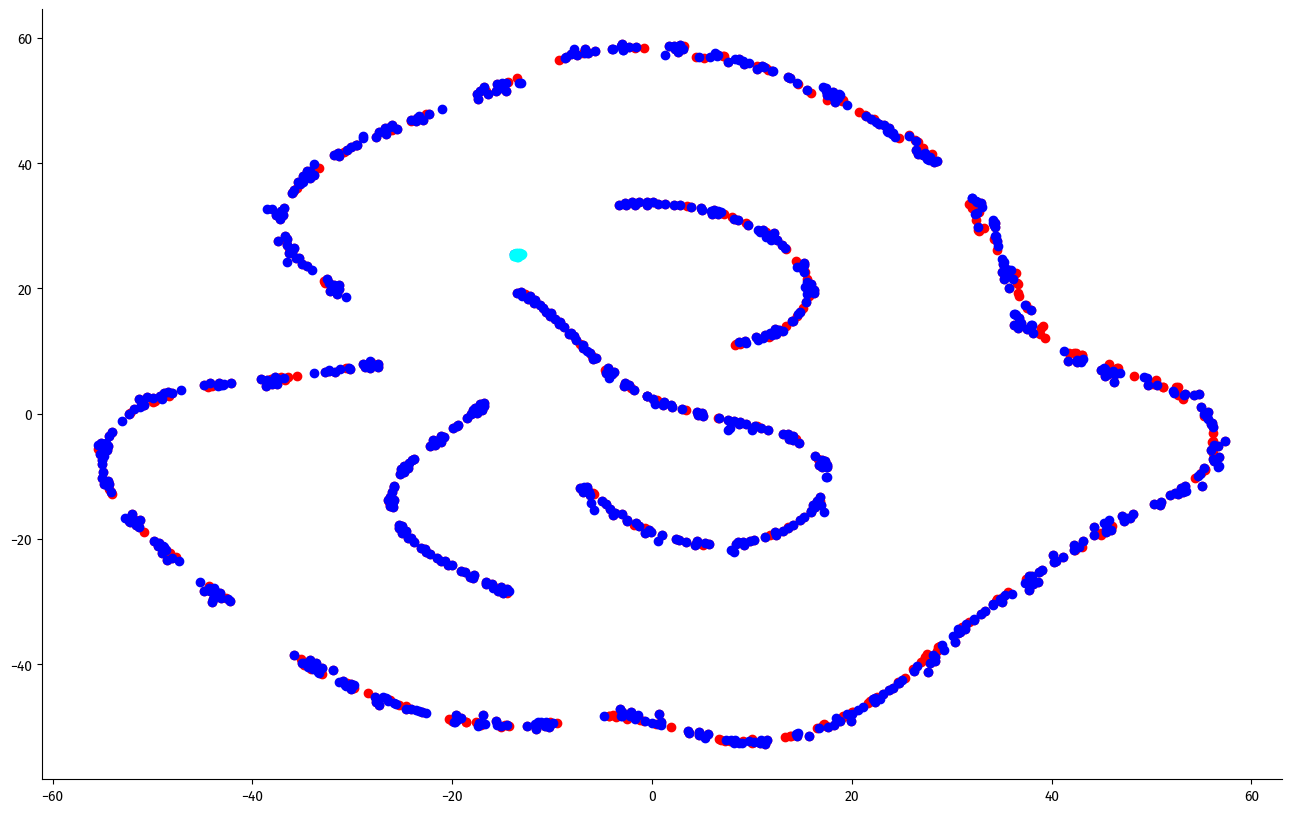

(1580, 2)


In [65]:

plt.figure(figsize=(16,10))
plt.scatter(X_embedded[:784, 0], X_embedded[:784, 1], c='r')
# plt.scatter(X_embedded[785:2*784+1, 0], X_embedded[785: 2*784+1, 1], c='pink')
#plt.scatter(X_embedded[2*784+1: -10, 0], X_embedded[ 2*784+1: -10, 1], c='blue')
plt.scatter(X_embedded[785: -10, 0], X_embedded[785: -10, 1], c='blue')
plt.scatter(X_embedded[-10:, 0], X_embedded[-10:, 1], c='cyan')
plt.show()
print(X_embedded.shape)

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7b6a9c03df30>)

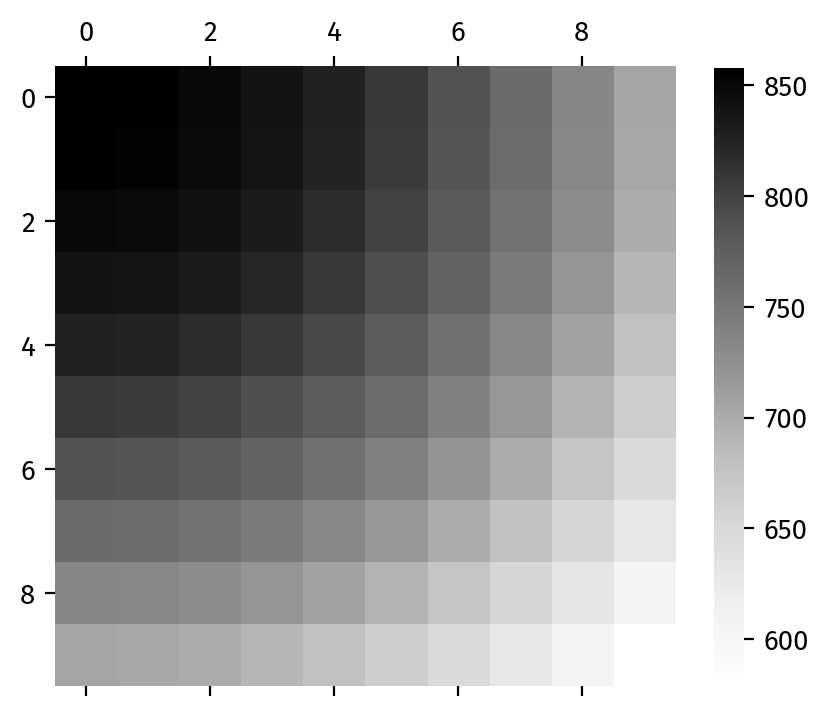

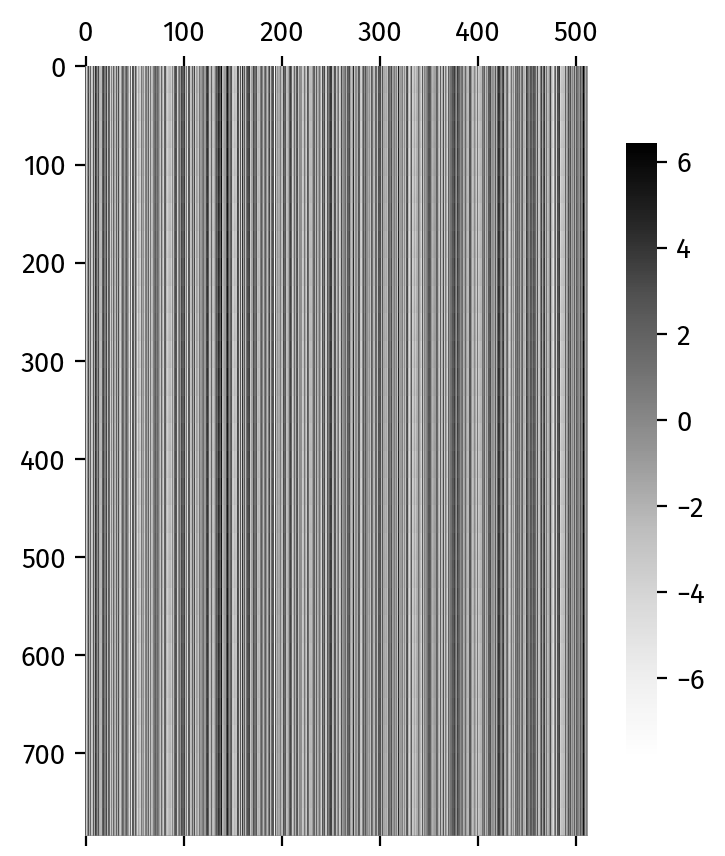

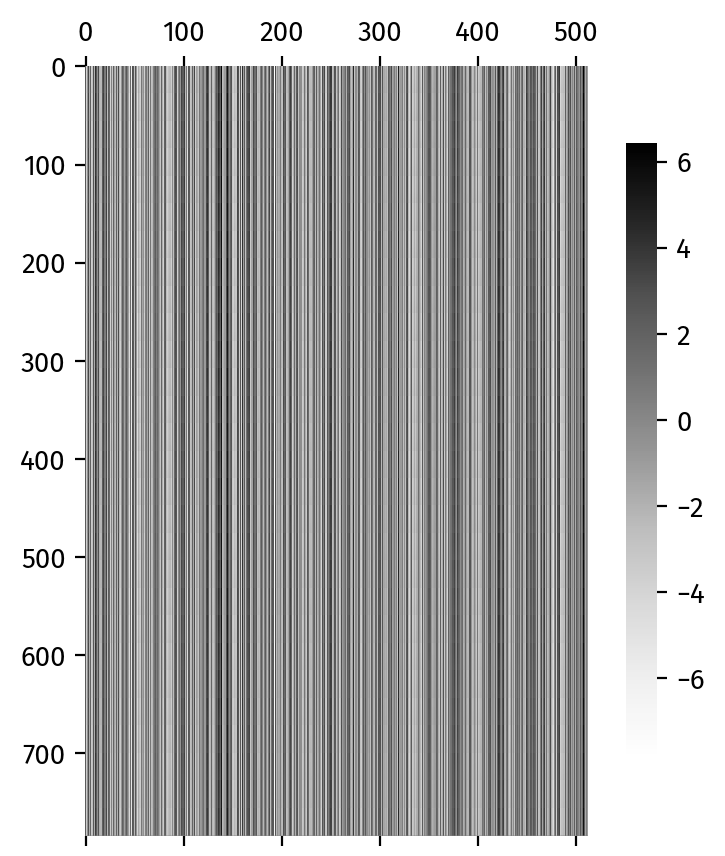

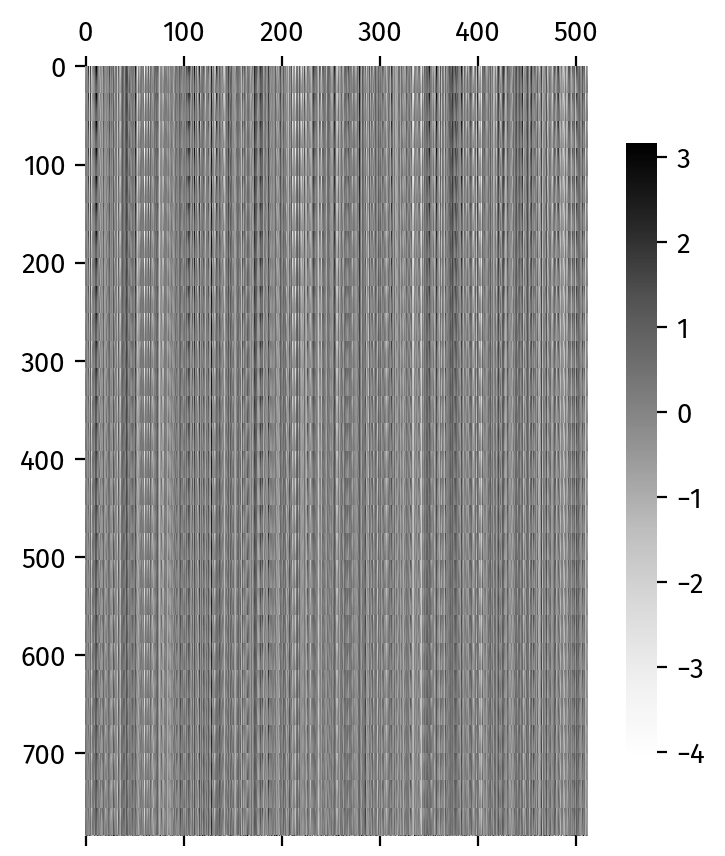

In [62]:
visualize_matrix(yd.T @ yd, dpi=200)
visualize_matrix(xyd1 , dpi=200)
visualize_matrix(xyd3 , dpi=200)
visualize_matrix(xyd2 , dpi=200)